# Прогнозирование поведения клиента

#### Импортируем нужные библиотеки

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

from scipy.optimize import minimize
from sklearn.metrics import r2_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_41372/2029515143.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


#### Выгружаем данные с винтажами

In [2]:
df = pd.read_csv(
    '../data/data_vintages.csv',
    sep=";",
    encoding="cp1251",
    index_col=0,
    date_parser=lambda x: pd.to_datetime(x), #преобразуем даты
    parse_dates=['gen_month_dt', 'gen_quarter_dt']
)
df.head(10)

/tmp/ipykernel_41372/2703565918.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(


,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
0,127336,19,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1
1,35907,16,2019-04-01,2019-04-01,1,0,0,0,1,0,0,0
2,45228,21,2019-05-01,2019-04-01,0,0,0,1,0,0,0,1
3,39035,23,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1
4,130780,19,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0
5,13089,14,2019-03-01,2019-01-01,0,0,0,1,0,0,0,1
6,132017,7,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0
7,67966,24,2019-06-01,2019-04-01,1,0,0,0,1,0,0,0
8,152759,11,2019-11-01,2019-10-01,0,0,1,1,0,0,0,1
9,128462,20,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0


#### Выгружаем данные со скорами для дальнейшей разбивки на бакеты

In [3]:
df_scores = pd.read_csv(
    '../data/data_scores.csv',
    sep=";",
    encoding="cp1251",
    decimal=',',
    index_col=0
)

df_scores.head(10)

,user_id,pd,x_score
0,9311,0.035025,0.219980
1,155026,0.046279,0.146986
2,17584,0.007221,0.343298
3,156231,0.069679,0.186684
4,123587,0.010402,0.305582
5,125519,0.032667,0.261228
6,123890,0.027963,0.199389
7,82137,0.073694,0.113313
8,55227,0.011746,0.335474
9,124825,0.049237,0.227262


#### Бъем выборку на бакеты и джойним с данными с винтажами

In [4]:
df_scores = df_scores.sort_values(['pd'], ignore_index=True)
df_scores['pd_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['pd_bucket'])['pd'].mean())

df_scores = df_scores.sort_values(['x_score'], ignore_index=True)
df_scores['x_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['x_bucket'])['x_score'].mean())

df = df.merge(df_scores[['user_id', 'pd_bucket', 'x_bucket', 'pd', 'x_score']], how='left', on='user_id').dropna()
df.head()

pd_bucket
0    0.011040
1    0.032685
2    0.068209
Name: pd, dtype: float64
x_bucket
0    0.133270
1    0.220838
2    0.379452
Name: x_score, dtype: float64


,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg,pd_bucket,x_bucket,pd,x_score
0,127336,19,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1,1,2,0.021296,0.469410
1,35907,16,2019-04-01,2019-04-01,1,0,0,0,1,0,0,0,2,0,0.064742,0.157215
2,45228,21,2019-05-01,2019-04-01,0,0,0,1,0,0,0,1,0,2,0.018490,0.469583
3,39035,23,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1,1,1,0.025882,0.210896
4,130780,19,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0,1,1,0.024330,0.269492


In [5]:
df_scores.groupby(['x_bucket'])['x_score'].mean().to_csv('./dlq_pa.csv')
df_scores.groupby(['pd_bucket'])['pd'].mean().to_csv('./dlq_pd.csv')

## Кривые DLQ ratio

Рассмотрим долю счетов в просрочке 1-3 ко всем активным счетам (активными называем счета находящихся в просрочке 0-3)
### $$DLQ ratio_n = \frac{\#DLQ_n}{\#ACT_n}$$

/tmp/ipykernel_33096/2076681768.py:6: FutureWarning: The provided callable <function sum at 0x78eb6df05cf0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\


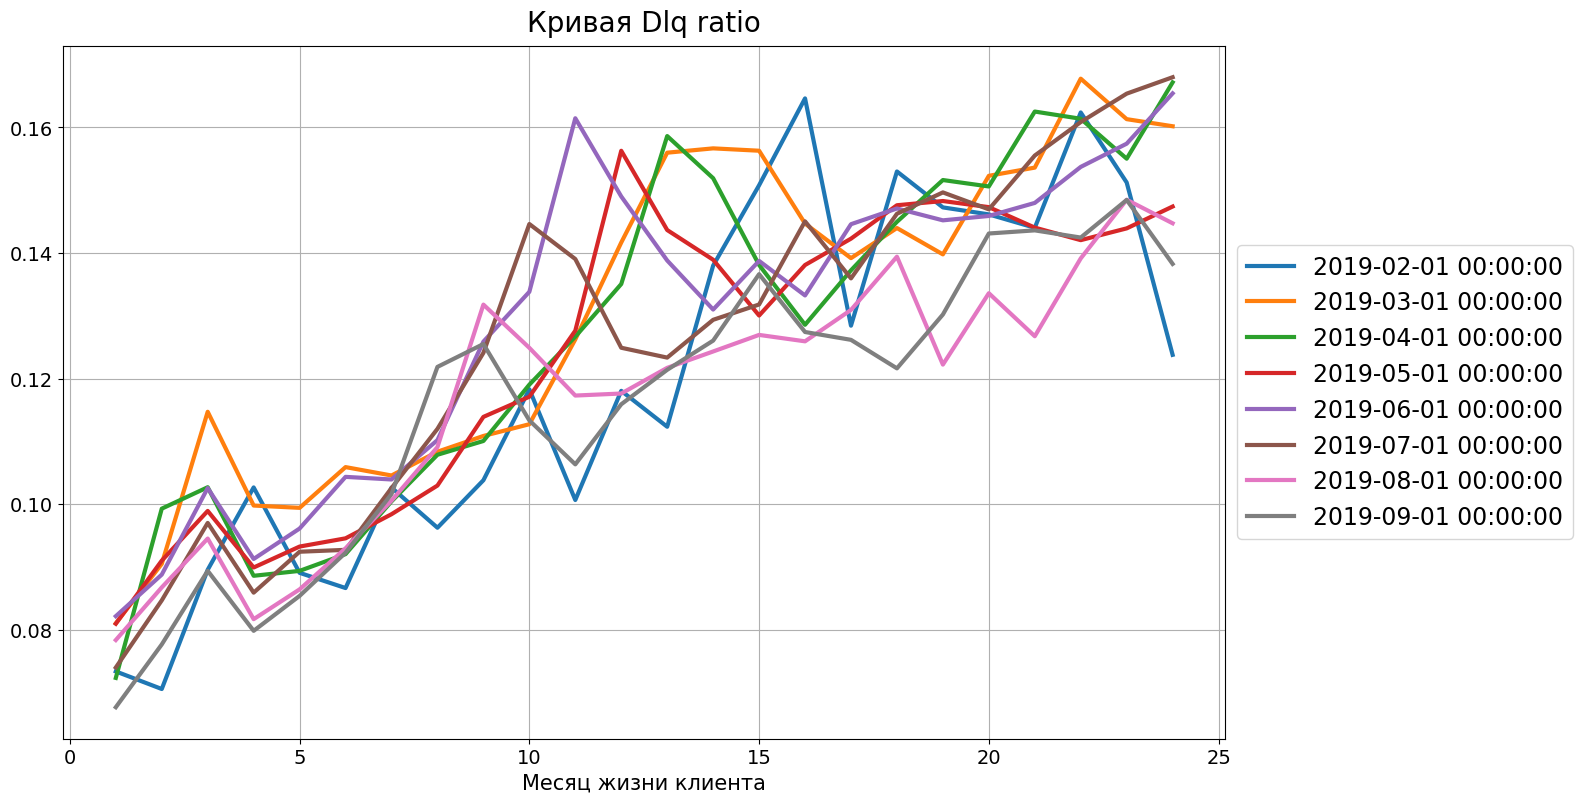

In [5]:
# DLQ ratio будем рассматривать по месяцам. Для удобства и наглядости возьмем только часть наблюдений
df = df[df['gen_month_dt'] < '2019-10-01']

def plot_dlq_ratio_by_generation(df):
    return (df.groupby(["gen_month_dt", "statement_num"])
            .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
            .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
            .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)\
            .unstack('gen_month_dt')
            ['dlq_ratio']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))               

# Строим график при помощи pyplot
plot_dlq_ratio_by_generation(df)

# Настраиваем параметры отображения графика
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Выберем параметр для разделения кривых

#### Разделение по PD

/tmp/ipykernel_33096/1828105924.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return (df.query(''' gen_month_dt == '2019-04-01' ''')
/tmp/ipykernel_33096/1828105924.py:4: FutureWarning: The provided callable <function sum at 0x78eb6df05cf0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\


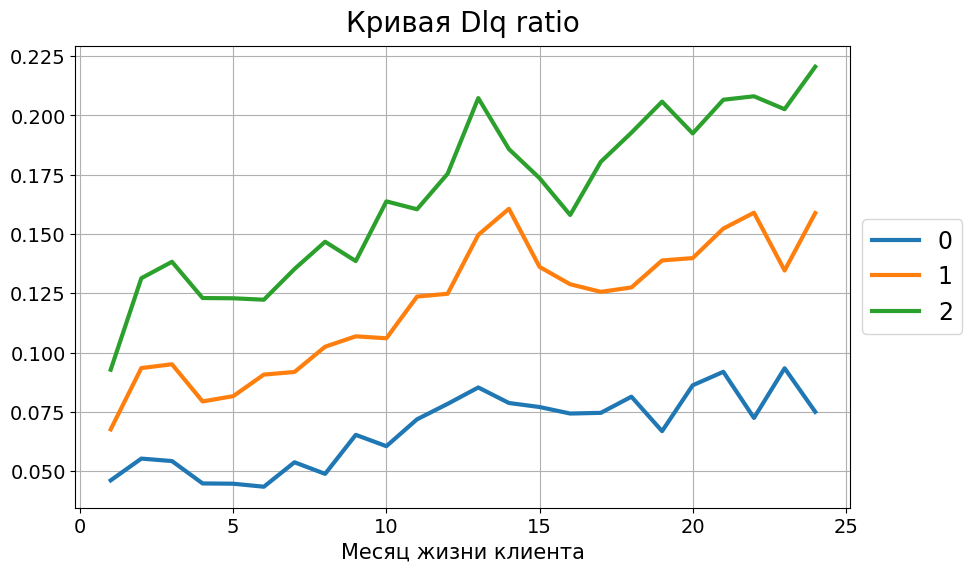

In [6]:
def plot_dlq_ratio_by_bucket(df, bucket):
    return (df.query(''' gen_month_dt == '2019-04-01' ''')
            .groupby([bucket, "statement_num"])
            .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
            .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
            .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)\
            .unstack(bucket)
            ['dlq_ratio']
            .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

plot_dlq_ratio_by_bucket(df, 'pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Разделение по скору Х

/tmp/ipykernel_33096/1828105924.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  return (df.query(''' gen_month_dt == '2019-04-01' ''')
/tmp/ipykernel_33096/1828105924.py:4: FutureWarning: The provided callable <function sum at 0x78eb6df05cf0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\


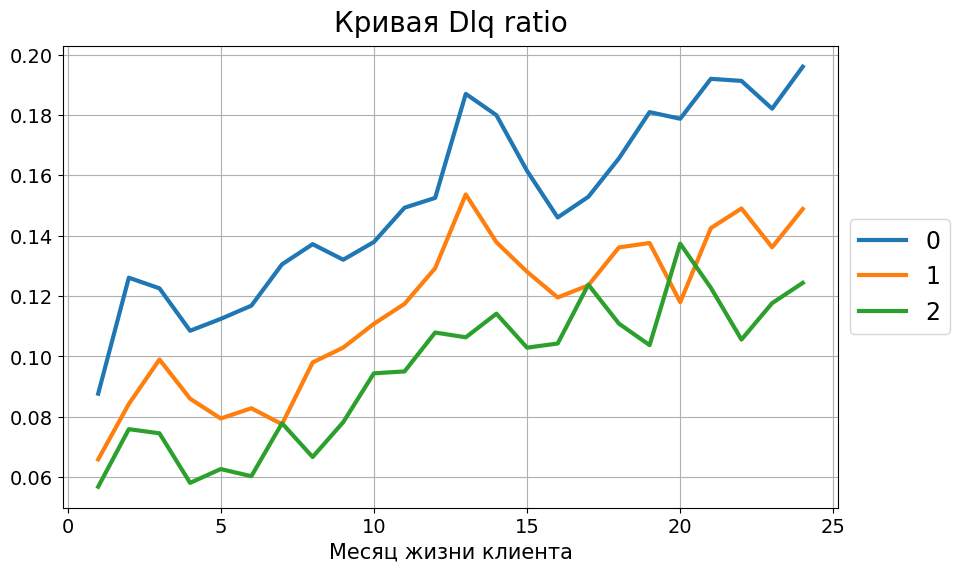

In [7]:
plot_dlq_ratio_by_bucket(df, 'x_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### При использовании PD кривые лежат дальше друг от друга, чем при использовании X_score, поэтому будем использовать PD

### Проверим выбору на странные поколения

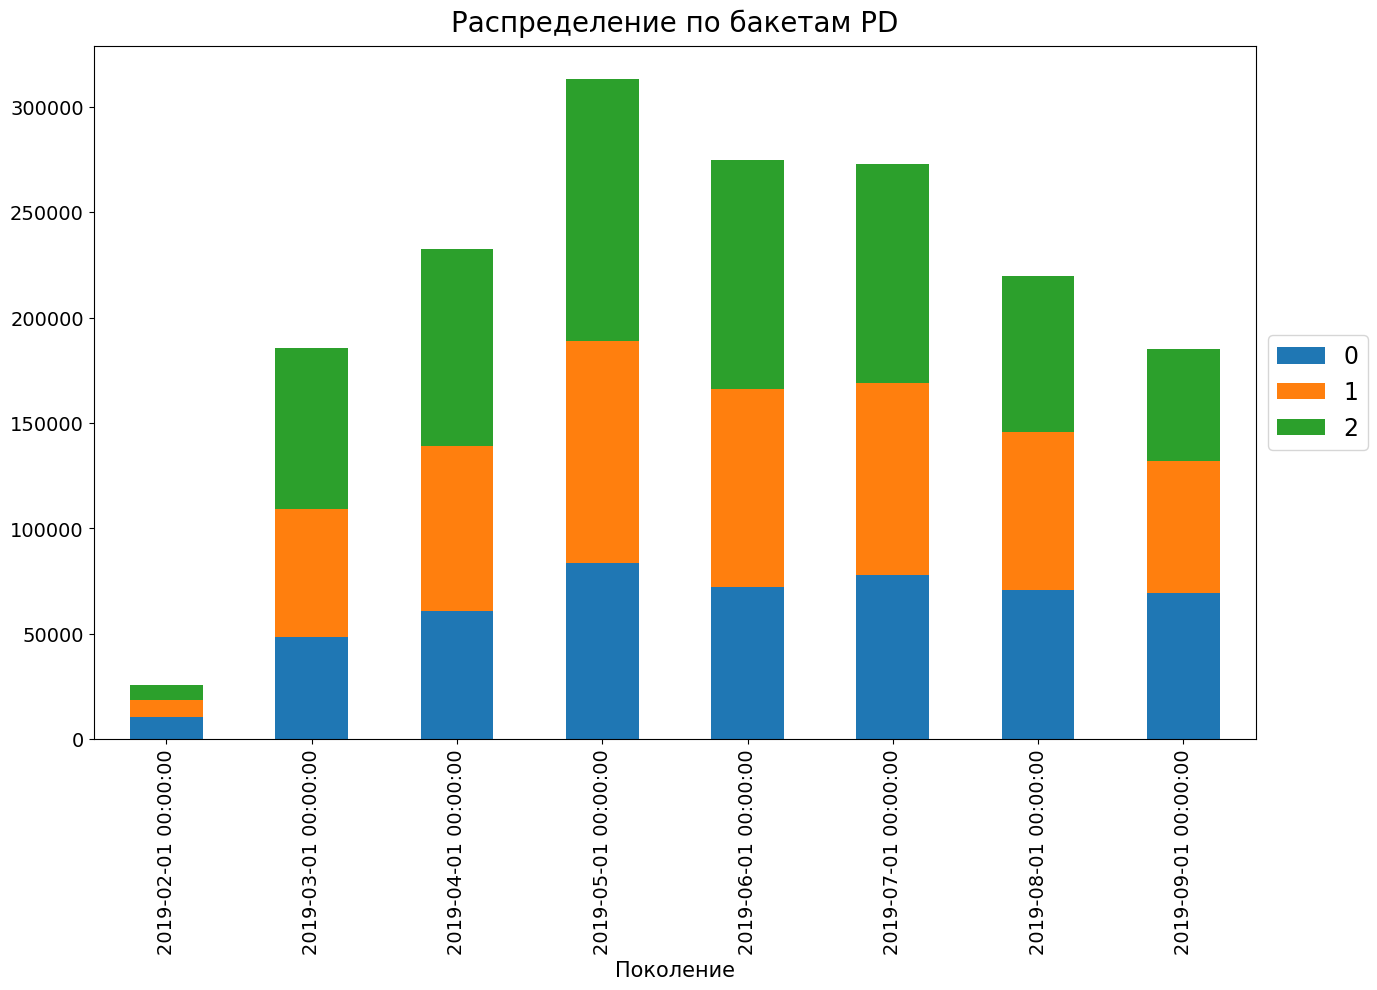

In [8]:
def plot_distribution(df, bucket):
    return pd.pivot_table(df, index=[bucket], columns='gen_month_dt',          # делаем сводную таблицу и транспонируем ее
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))                    # Рисуем график распределения столбиками

plot_distribution(df, 'pd_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам PD", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Во феврале 2019 года мало наблюдений (25000 на три бакета по 24 платежа), исключим это поколение из рассмотрения 

#### Рассмотрим поколения в разбивке по бакетам

/tmp/ipykernel_33096/1791009799.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df.query(exception_query, inplace = True)
/tmp/ipykernel_33096/1791009799.py:16: FutureWarning: The provided callable <function sum at 0x78eb6df05cf0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
/tmp/ipykernel_33096/1791009799.py:16: FutureWarning: The provided callable <function sum at 0x78eb6df05cf0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"dlq_flg":np.sum, "act_flg

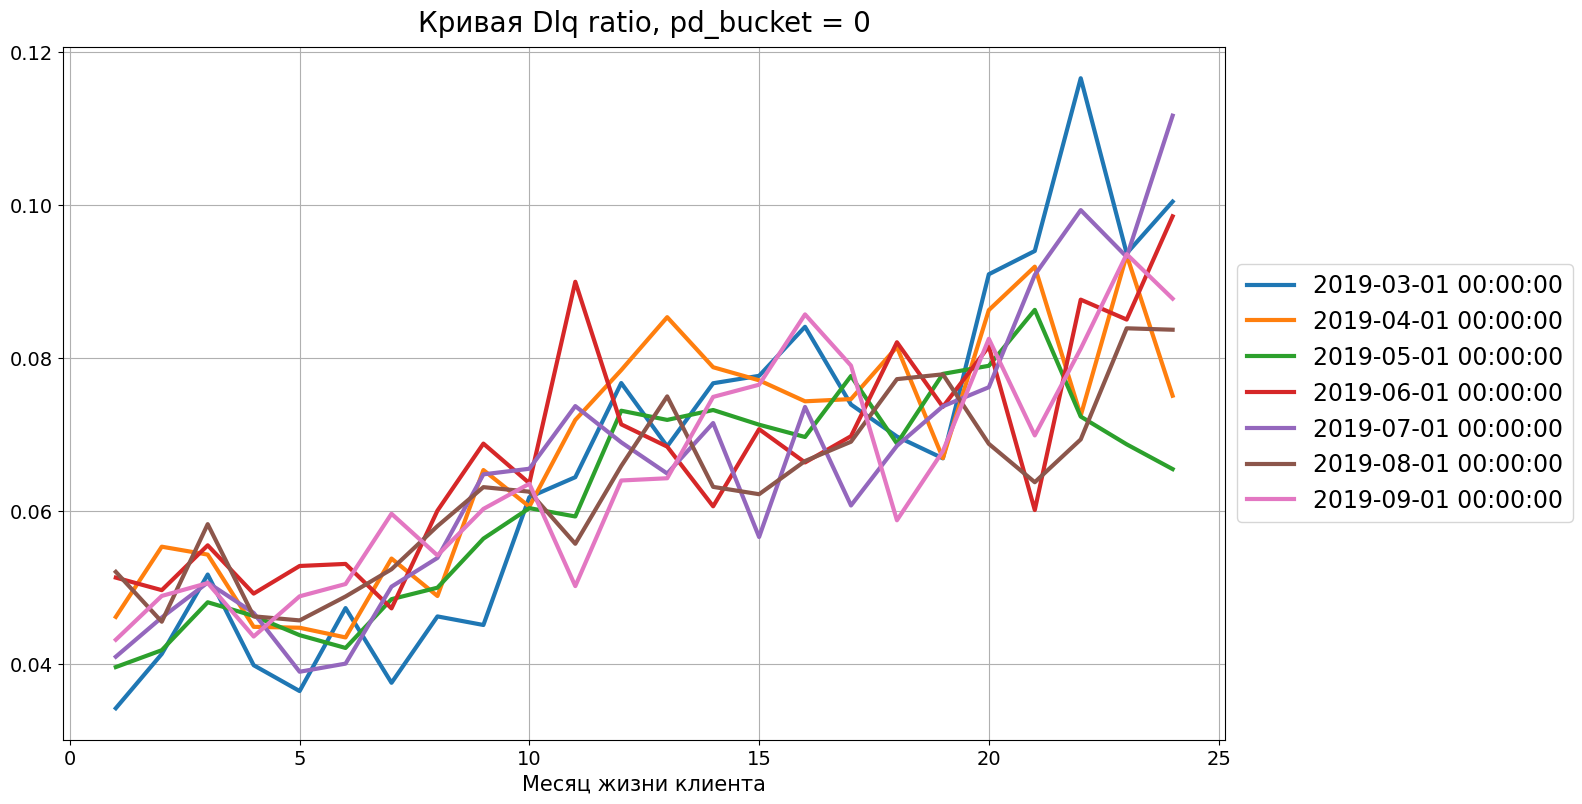

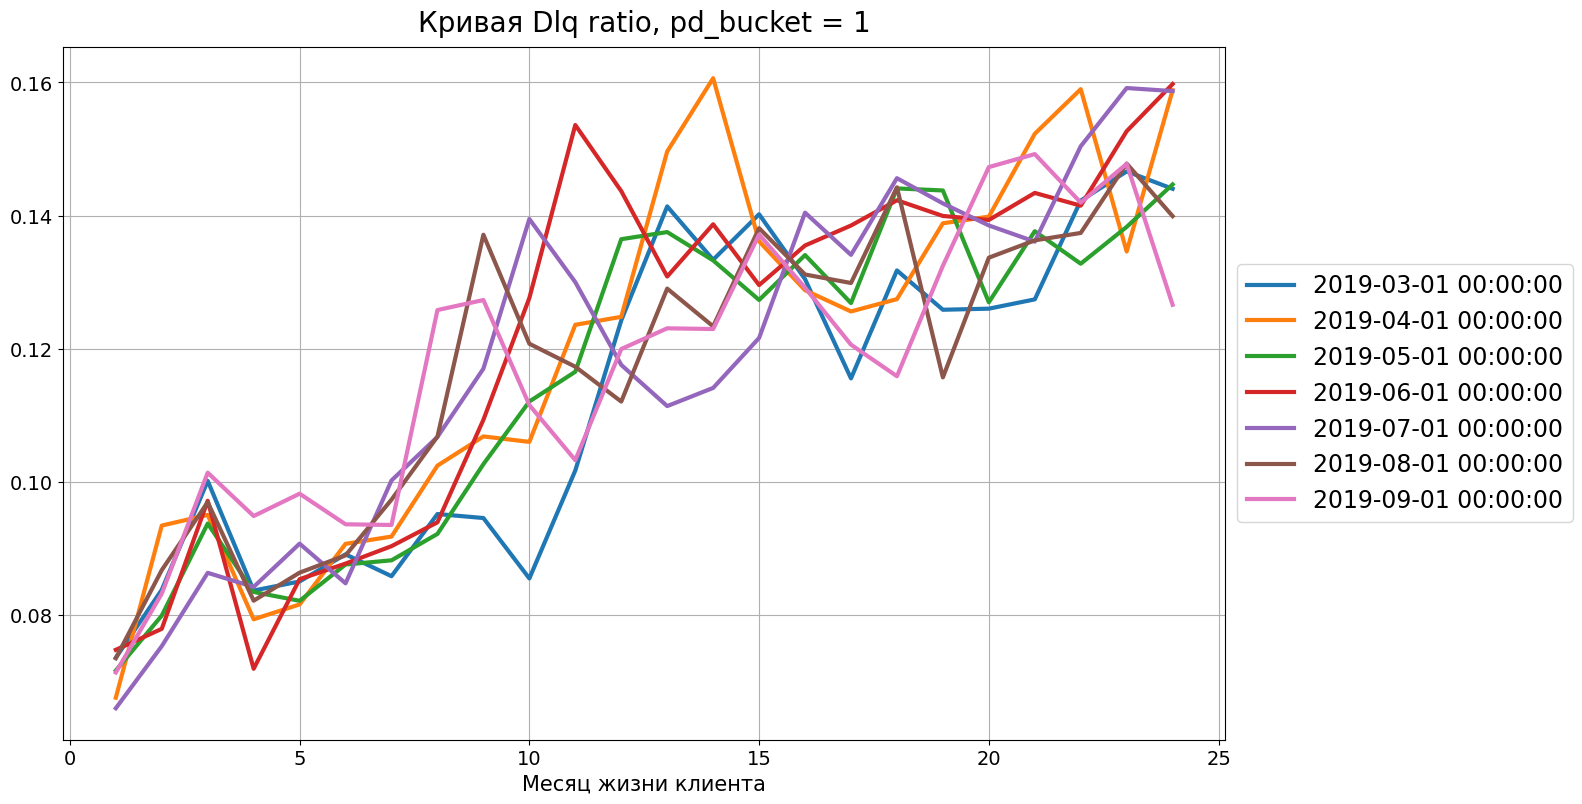

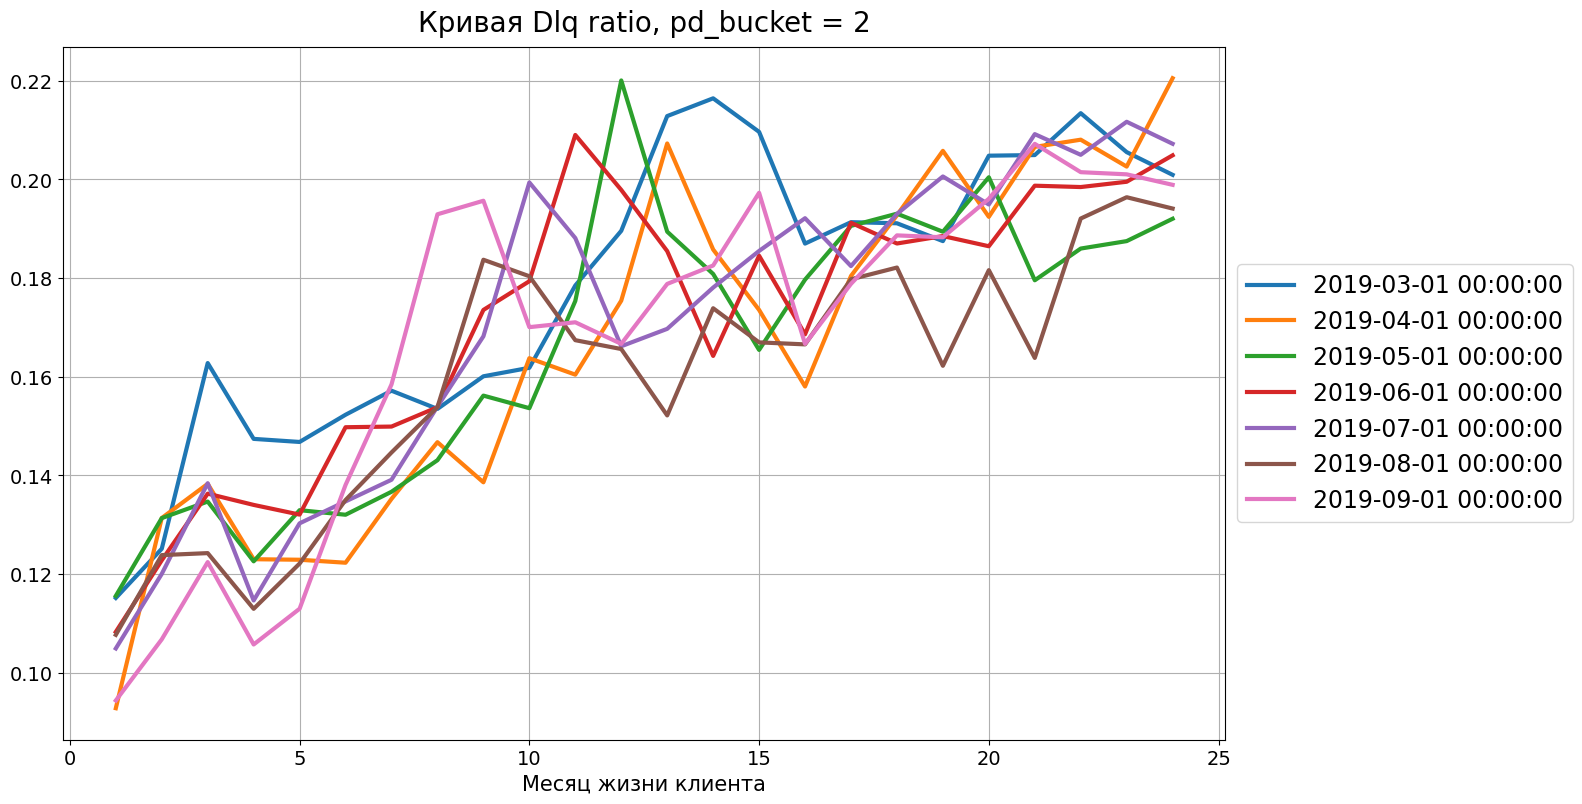

In [9]:
# Исключаем плохое поколение

exception_query = ''' ~((gen_month_dt == '2019-02-01')) '''
df.query(exception_query, inplace = True)

# Делаем список бакетов

buckets = df['pd_bucket'].drop_duplicates().sort_values(ascending = True)


# Строим график, который зависит от бакета

def plot_dlq_ratio_by_generation(data, pd_bucket):
    data_tmp = data.query(''' pd_bucket == @pd_bucket''')\
        .groupby(["gen_month_dt", "statement_num"])\
        .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
        .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
        .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)\
        .unstack('gen_month_dt')['dlq_ratio']\
        .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая Dlq ratio, pd_bucket = " + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

    
for i in buckets:
    plot_dlq_ratio_by_generation(df, i)


## Вычищение макроэкономических воздействий

Видим, что в винтажах dlq ratio присутсвуют внешние воздействия. Вычистим их с помощью разложения винтажей на две матрицы.

##### Напомним идею разложения.

Сделаем обозначения:

$t$  - календарное время;

$n$  - номер поколения;

$(t−n)$  - месяц жизни клиента;


$D(t,n)$  - значения исследуемой кривой (Delinquency ratio) в месяц  $t$  для поколения номер  $n$ ;

$E(t)$  - внешние воздействия, которые зависят только от календарного времени  $t$ ;

$M(t−n)$  - кривая созревания, которая зависит только от месяца жизни клиента  $(t−n)$ .


Будем предполагать, что в идеальном случае существует разложение
$$D(n,t)=E(t)M(t−n)$$
 

Для поиска данного разложения будем минимизировать функционал
$$ F(E,M)=\sum_{n,t}{(D(t,n)−E(t)M(t−n))}^2 \to \min_{E,M} $$
 
где  $E={E(t),t>0}$, $M={M(t−n),t−n>0}$

#### Функции, которые реализую разложение матрицы

In [10]:
def curve_build(data,
                feature,
                generation='generation_quart',
                statement_num='statement_num',
                group_label='1'):
    """Вспомогательная функция для построения разложения в рамках одного бакета
    **Аргументы**
    data : pandas.DataFrame
        таблица с данными
    feature: str
        название поля с исследуемой переменной
    generation : datetime
        название поля с поколениями
    where : str
        условие, которым мы ограничиваем выборку
    statement_num : int
        название поля с номером месяца жизни клиента
    group_label : str
        название поля группы
    **Результат**
    dictionary : dict
    """
    df_query = data.sort_values([generation, statement_num]).reset_index()

    # Рассчитываем количество поколений и тому подобное
    generation_min = df_query[generation].min()
    gen_cnt = df_query[statement_num].max()

    # Преобразуем Dataframe в набор векторов
    values = np.array(df_query[feature])
    tab_size = df_query[feature].count()
    st_nums = np.array(df_query[statement_num] - 1)
    dates = np.array([0 for i in range(tab_size)])

    for i in range(tab_size):
        dates[i] = df_query.loc[i, generation].year * 12 + df_query.loc[i, generation].month -\
        generation_min.year * 12 - generation_min.month + df_query.loc[i, statement_num] - 1

    # Определяем функционал, который будем минимизировать
    def r_square(x):
        temp = 0
        for i in range(tab_size):
            if dates[i] >= 0:
                temp += (values[i] - x[dates[i]] * x[st_nums[i] + gen_cnt]) ** 2
        return temp

    # Задаем callback для отслеживания прогресса минимизации
    def callbackF(Xi):
        global Nfeval
        print('%d  %.6f' % (Nfeval, r_square(Xi)))
        Nfeval += 1

    # Задаем начальное приближение в виде массива с нулевыми значениями
    x0 = np.array([0.001 for i in range(2*gen_cnt)]) # Внешние воздействия #!!!

    # Численная минимизация
    print('Initial %.6f' % (r_square(x0)))
    res0 = minimize(r_square, x0, tol=1e-6, callback=callbackF, method='Powell',
                    options = {'disp': False, 'maxiter': 1000})

    # Задаем датафрейм с внешними воздействиями
    external_data = pd.DataFrame({'month_dt': [generation_min + pd.DateOffset(months=i) for i in range(gen_cnt)],
                                  group_label: res0.x[: gen_cnt]})
    # external_data['month_dt'] = pd.to_datetime(external_data['month_dt']) #!!!

    # Нормируем внешние воздействия таким образом, чтобы в среднем они равнялись единице.
    ext_mean = external_data[external_data['month_dt'] > generation_min + pd.DateOffset(months=6)][group_label].mean()
    external_data[group_label] = external_data[group_label] / ext_mean

    # И умножаем на полученный коэффициент кривые созревания
    maturation_array = np.transpose([res0.x[gen_cnt: 2 * gen_cnt] * ext_mean]).flatten()
    maturation_data = pd.DataFrame(data = {group_label: maturation_array,
                                           'statement_num': np.arange(1, maturation_array.size + 1)})

    df_fitted = df_query.merge(right=external_data, on='month_dt')
    df_fitted['fitted_feature'] = df_fitted[feature] / df_fitted[group_label]

    # Формируем словарь c итоговыми данными
    res = {'res0': res0,
          'external_data': external_data,
          'maturation_data': maturation_data,
          'df_fitted': df_fitted}
    return res

def decomposition(df, 
                  generation = 'generation_month', 
                  group = 'bucket', 
                  statement_num = 'statement_num', 
                  feature = 'feature', 
                  optimization_query = ''):
    """Винтажи исследуемой переменной по календарному времени
    
    **Аргументы**
    df : pandas.DataFrame
        таблица с данными
    generation : datetime
        название поля с поколениями
    group : str
        название поля с бакетами
    statement_num : int
        название поля с номером выписки
    feature: str
        название поля с исследуемой переменной
    optimization_query: str
        ограничение выборки для оптимизации
    **Результат**
    dictionary : dict
    """

    # Разбираемся со случаем пустых аргументов
 
    if optimization_query == '':
        df_query = pd.DataFrame(df)
        df_query[generation] = pd.to_datetime(df_query[generation])

    else:
        df_query = df.query(optimization_query)

    timedelta = df_query[statement_num].apply(lambda x: pd.DateOffset(months=x-1))
    df_query['month_dt'] = df_query[generation] + timedelta
    df_query['month_dt'] = pd.to_datetime(df_query['month_dt'])
    
      # Формируем список бакетов
    
    df_query.sort_values(by = [group], inplace = True)
    groups = pd.Series(df_query[group].drop_duplicates())
    
    # Запускаем цикл по бакетам
    i = 0
    for g in groups:
        df_temp = df_query[df_query[group] == g]
        print(group + ' = ' + str(g))
        
        # Строим разложение для одного бакета
        res = curve_build(df_temp, 
                          feature = feature, 
                          generation = generation, 
                          statement_num = statement_num, 
                          group_label = str(g)
                         )
        df_fitted_temp = pd.DataFrame(res['df_fitted'])
        df_fitted_temp[group] = g

        # Если первый шаг в цикле, то формируем датафреймы из результатов минимизации
        if i == 0:
            external_data = pd.DataFrame(res['external_data'])[['month_dt', str(g)]]
            maturation_data = pd.DataFrame(res['maturation_data'])[[statement_num, str(g)]]
            df_fitted = pd.DataFrame(df_fitted_temp)
        # Если шаг не первый, то дописываем столбцы в результаты
        else:
            external_data = external_data.merge(right = res['external_data'], on = ['month_dt'])
            maturation_data = maturation_data.merge(right = res['maturation_data'], on = [statement_num])
            df_fitted = pd.concat([df_fitted, df_fitted_temp]) 
        i+=1
        
    res_multiple = {
                    'external_data': external_data,
                    'maturation_data': maturation_data,
                    'fitted_data': df_fitted
                   }    
    return res_multiple

#### Применим функцию к нашим данным

In [11]:
# Подготавливаем данные
df_ratio = df.groupby(["pd_bucket","gen_month_dt", "statement_num"], as_index=False)\
        .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
        .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
        .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)


# Счетчик итераций
Nfeval = 0

# Проводим разложение кривых 
res = decomposition(df_ratio, 
                       generation = 'gen_month_dt', 
                       group = 'pd_bucket', 
                       statement_num = 'statement_num', 
                       feature = 'dlq_ratio')

/tmp/ipykernel_33096/2054118202.py:3: FutureWarning: The provided callable <function sum at 0x78eb6df05cf0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
/tmp/ipykernel_33096/266946895.py:120: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_query['month_dt'] = df_query[generation] + timedelta


pd_bucket = 0
Initial 0.761731
0  0.153048
1  0.152087
2  0.151630
3  0.150431
4  0.150286
5  0.150196
6  0.150134
7  0.150090
8  0.150057
9  0.150033
10  0.150016
11  0.150003
12  0.149994
13  0.149987
14  0.149982
15  0.149978
16  0.149975
17  0.149973
18  0.149972
19  0.149970
20  0.149970
21  0.149969
22  0.149969
23  0.149968
24  0.149968
25  0.149968
26  0.149968
pd_bucket = 1
Initial 2.423483
27  0.450626
28  0.449798
29  0.449327
30  0.448951
31  0.447409
32  0.447399
33  0.447398
34  0.447398
pd_bucket = 2
Initial 4.925166
35  0.848533
36  0.844911
37  0.842725
38  0.841089
39  0.835224
40  0.834915
41  0.834758
42  0.834666
43  0.834606
44  0.834566
45  0.834538
46  0.834518
47  0.834504
48  0.834494
49  0.834486
50  0.834481
51  0.834477
52  0.834474
53  0.834472
54  0.834471
55  0.834470
56  0.834469


#### Получившиеся кривые внешних воздействий

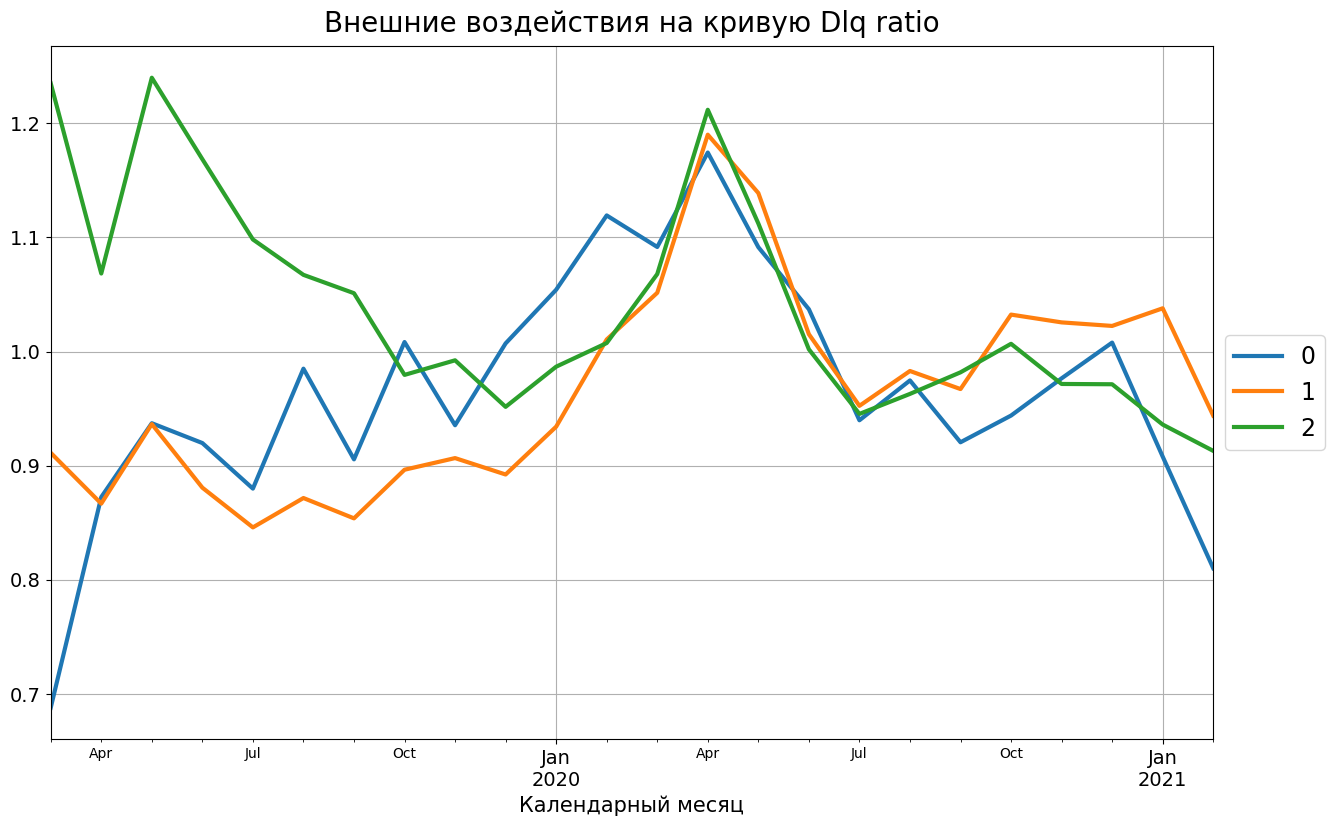

In [12]:
res['external_data'].set_index('month_dt')\
                    .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Внешние воздействия на кривую Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Календарный месяц", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Кривые DLQ ratio, вычищенные от внешних воздействий

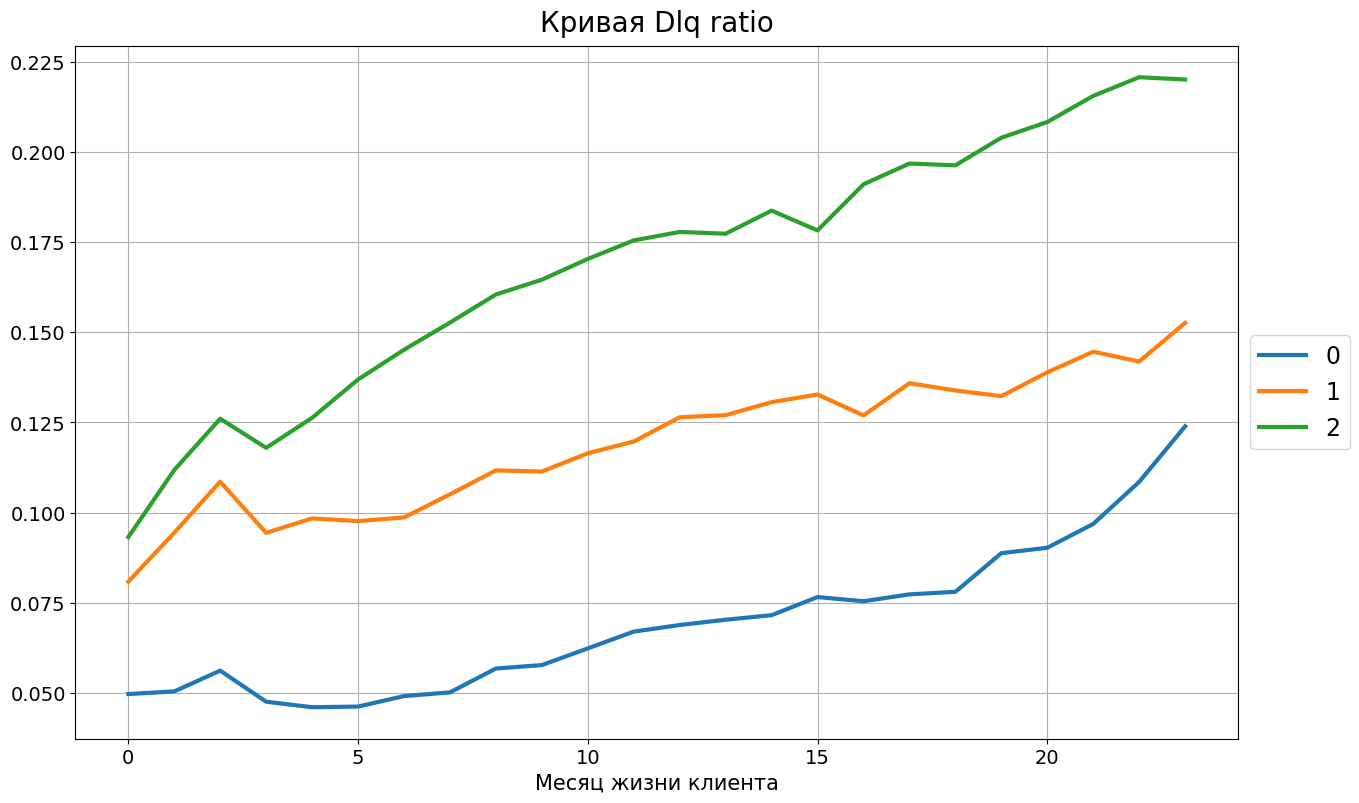

In [14]:
res['maturation_data'].drop('statement_num', axis=1).plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вычищенные кривые в разбивке по поколениям

/tmp/ipykernel_33096/450433842.py:4: FutureWarning: The provided callable <function mean at 0x78eb6df06c20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  .agg({'fitted_feature':np.mean})\
/tmp/ipykernel_33096/450433842.py:14: FutureWarning: The provided callable <function sum at 0x78eb6df05cf0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"fitted_feature":np.sum})\
/tmp/ipykernel_33096/450433842.py:14: FutureWarning: The provided callable <function sum at 0x78eb6df05cf0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  .agg({"fitted_feature":np.sum})\
/tmp/ipykernel_33096/450433842.py:14: FutureWarning: The p

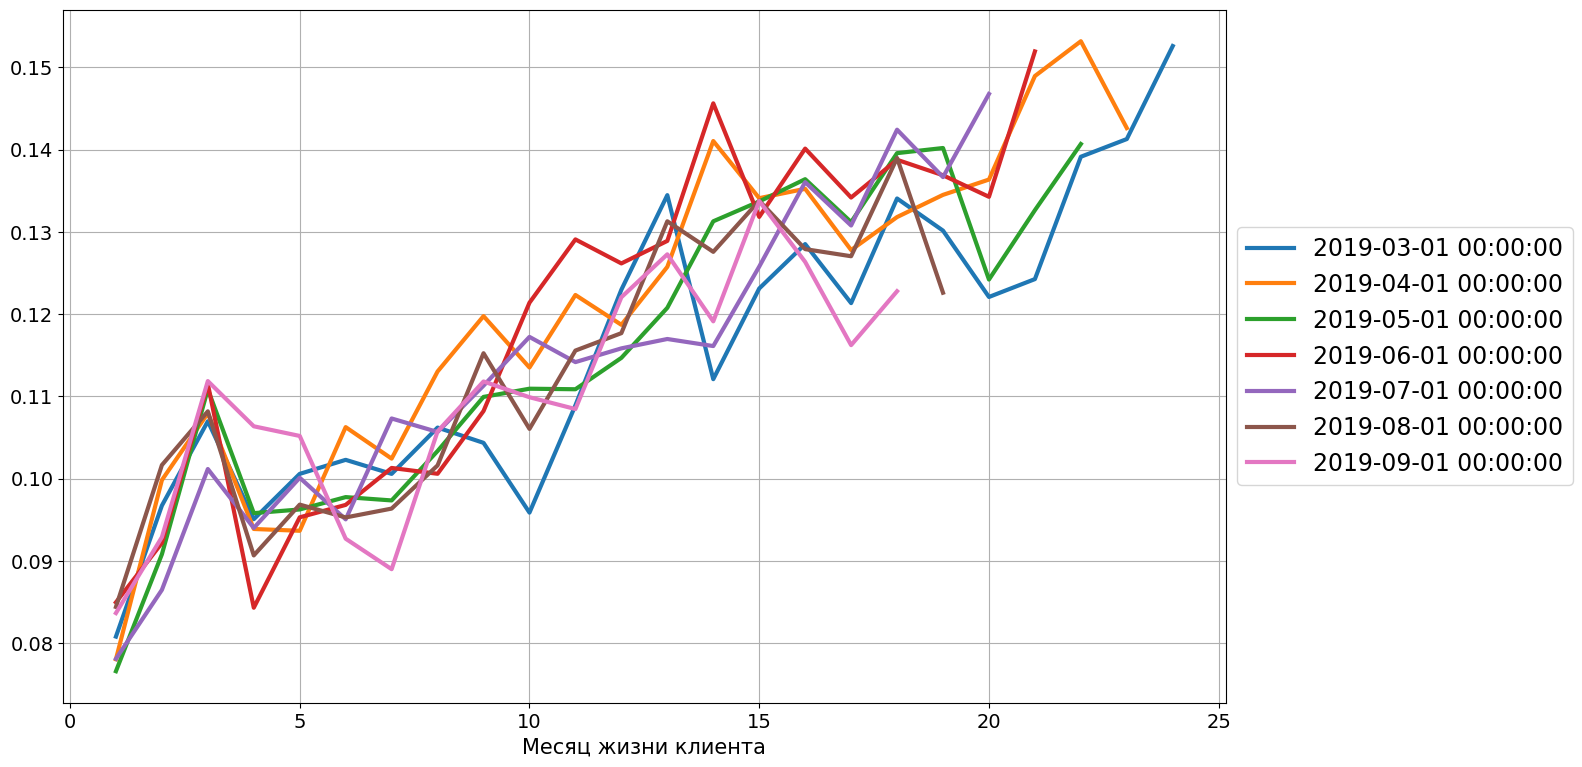

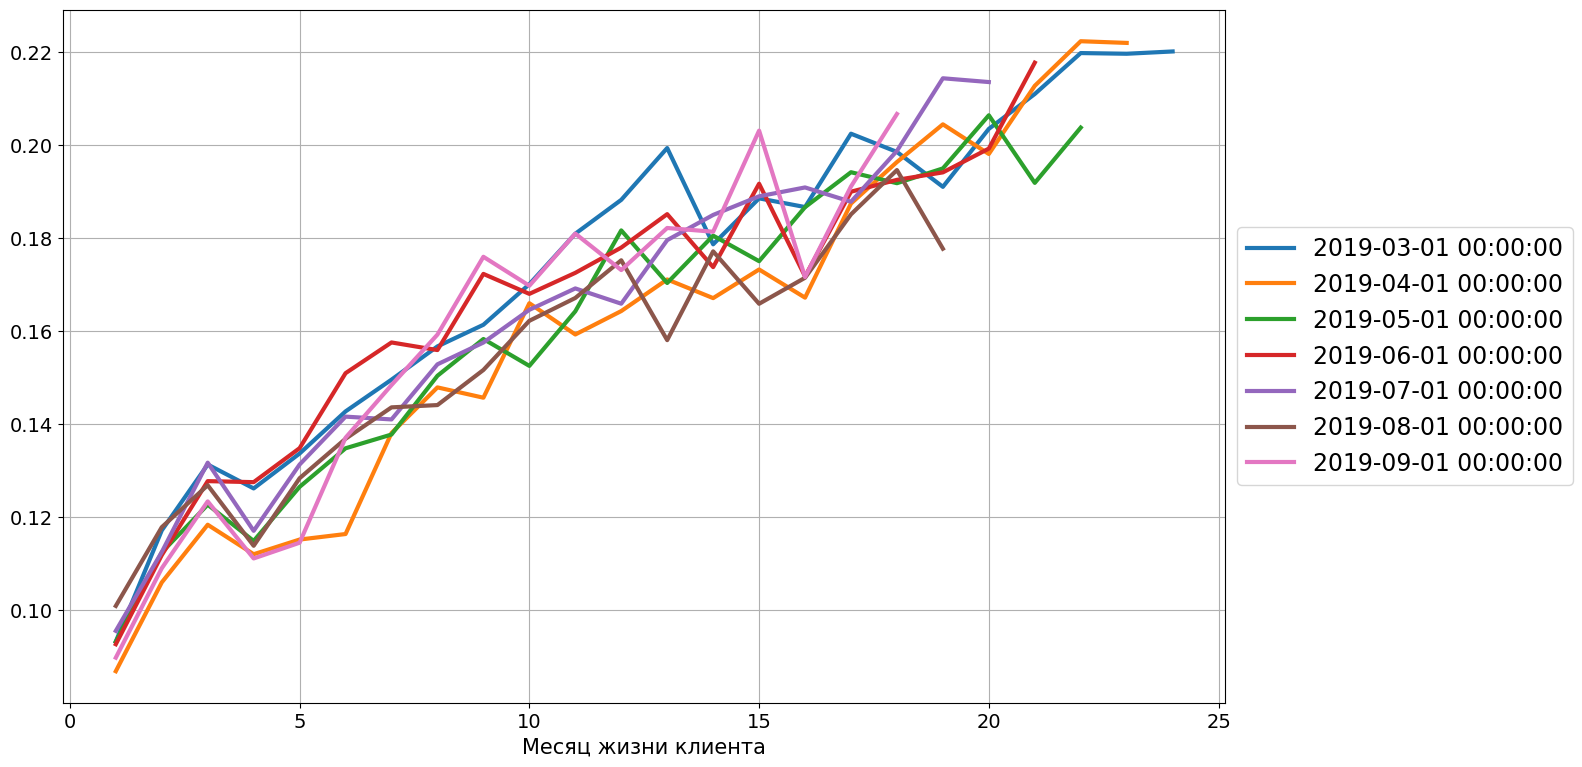

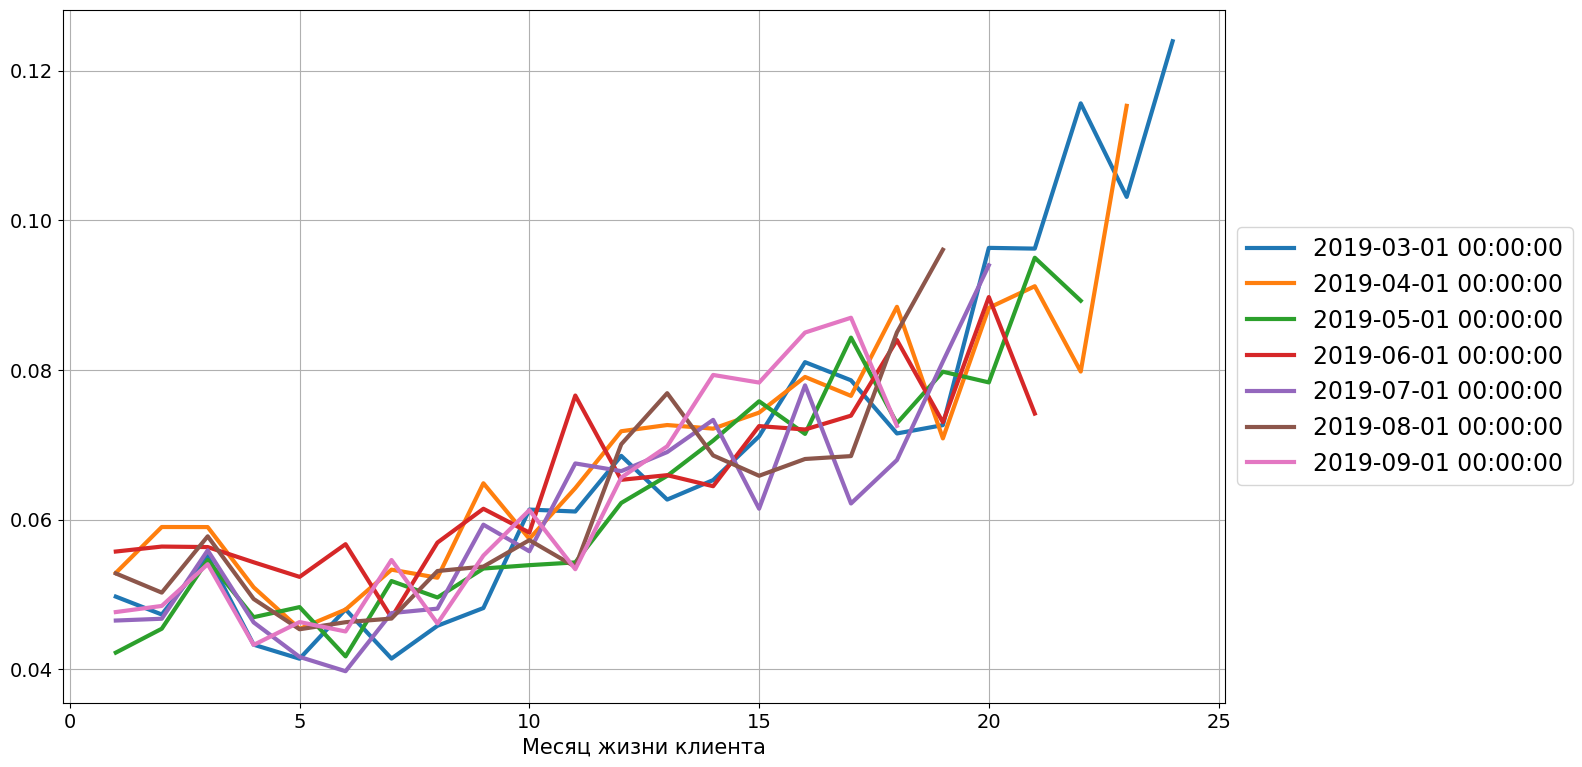

In [16]:
# Считаем среднее

dlq_ratio_mean = res['fitted_data'].groupby([ 'pd_bucket', 'statement_num'])\
    .agg({'fitted_feature':np.mean})\
    .rename(columns = {'fitted_feature':'Среднее'})

buckets = df['pd_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_dlq_ratio_mean(pd_bucket):
    vintages_graph = res['fitted_data'].query('pd_bucket == ' + str(pd_bucket))\
            .groupby(["gen_month_dt", "statement_num"])\
            .agg({"fitted_feature":np.sum})\
            .unstack('gen_month_dt')\
            ['fitted_feature']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
#     (dlq_ratio_mean.query('pd_bucket == ' + str(pd_bucket))['Среднее']
#              .plot( figsize=(15, 9), grid=True, lw = 3, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    # plt.title("Кривая Dlq ratio, pd_bucket =" + str(pd_bucket), "", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

for i in buckets:
    plot_dlq_ratio_mean(i)

### Найдем лучшую функцию для сглаживания кривых

In [17]:
def linear_approximation(df, start=1, finish=24):
    df_res = pd.DataFrame(df)
    df_res['Линейная функция'] = df['Среднее']                                                # Копируем средние значения
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], 1)  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)                                                    # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, 'Линейная функция'] = linear_coeff(np.arange(start, finish+1))   # Записываем приближение
    df_res.loc[finish+1:, 'Линейная функция'] = linear_coeff(finish+1)                        # Продолжаем кривую константой
    return df_res

def polynom_approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']                   
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)                                                 
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1)) 
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)                    
    return df_res

def exponential_smoothing(df, start, finish, alpha):
    df_res = pd.DataFrame(df)
    result = [df_res.loc[i,'Среднее'] for i in np.arange(1,start+1)]                              # Начальные значения копируем
    for n in range(start, len(df_res['Среднее'])): 
        result.append(float(alpha * df_res.loc[n + 1, 'Среднее'] + (1 - alpha) * result[n-1]))    # Делаем сглаживание
    df_res['Скользящее среднее'] = result
    return df_res

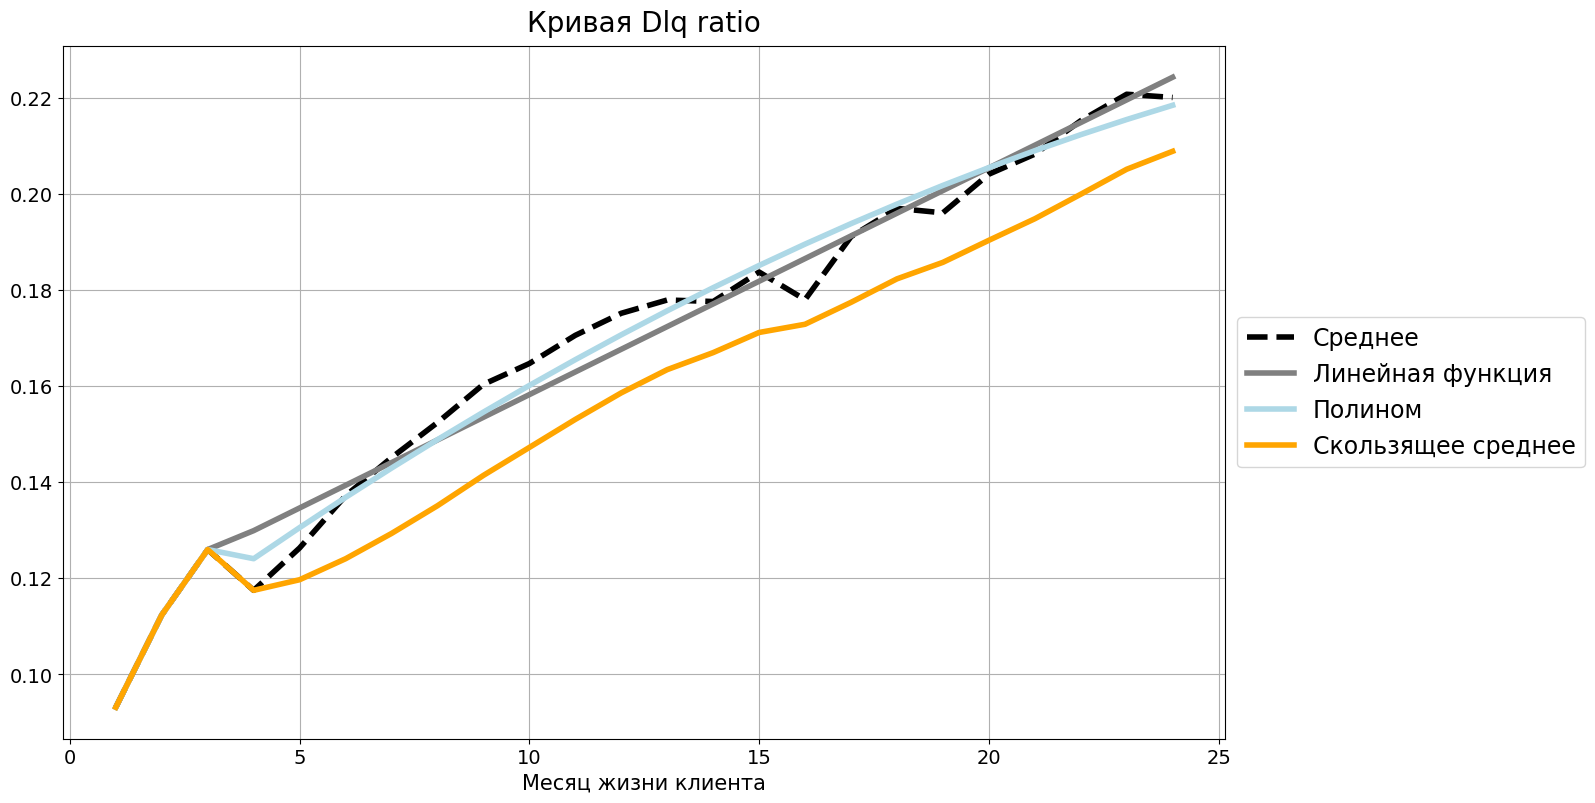

In [18]:
df_linear = dlq_ratio_mean.query('pd_bucket == 2').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 4, 24)
df_polynom = polynom_approximation(df_linear, 4,24,2)
df_smooth = exponential_smoothing(df_polynom, 4,24, 0.25)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Для приближения воспользуемся полиномом и сгладим все кривые

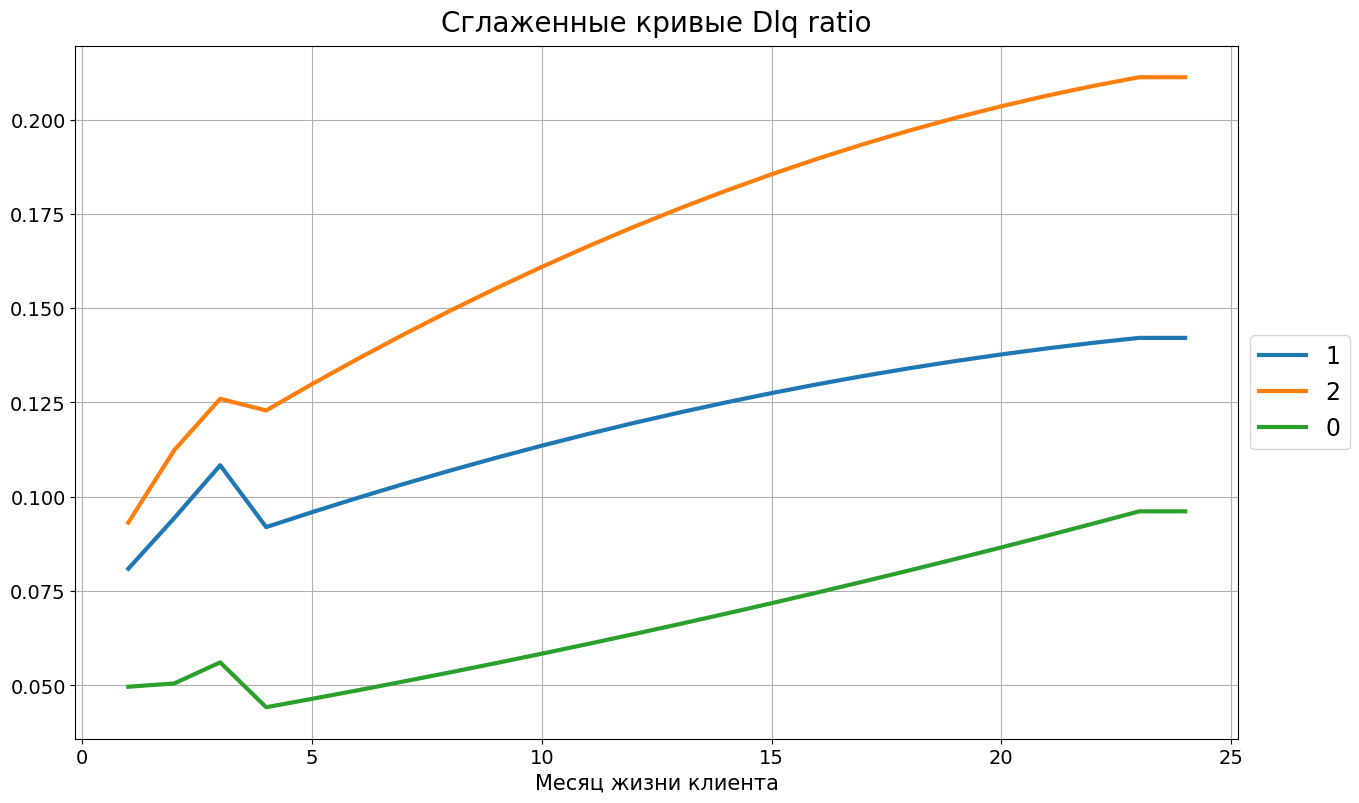

In [19]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

buckets = df['pd_bucket'].drop_duplicates()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = dlq_ratio_mean.query('pd_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 4,22,2)['Полином']

# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

In [20]:
df_smooth_result.to_csv('dlq_ratio.csv')